In [125]:
import jax
import jax.numpy as jnp
import jax.scipy.special
import dataclasses
from dataclasses import replace
from functools import partial

from copy import deepcopy, copy

import vtk
from vtk.util import numpy_support

import jaxdem as jd

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

from rattlers import *

In [226]:
def calculate_packing_fraction(state, system):
    return jnp.sum(state.volume) / jnp.prod(system.domain.box_size)

def scale_by_packing_fraction_offset(state, system, offset, copy=False):
    """
    Scale the state and system to packing fraction + offset.
    Optionally return a copy of the state and system.
    """
    if copy:
        new_state = replace(state)
        new_system = replace(system)
    else:
        new_state = state
        new_system = system

    packing_fraction = calculate_packing_fraction(new_state, new_system)
    scale = (packing_fraction / (packing_fraction + offset)) ** (1 / state.dim)
    new_state.pos_c *= scale
    new_system.domain.box_size *= scale
    return new_state, new_system

def calculate_kinetic_energy(state):
    """
    Calculate the kinetic energy for each particle.
    """
    ke_t = 0.5 * state.mass * jnp.sum(state.vel ** 2, axis=-1)
    ke_r = 0.5 * jnp.sum(state.inertia * state.angVel ** 2, axis=-1)
    return ke_t + ke_r

def dof_disk(state):  # TODO: account for state.fixed!
    return state.dim * state.N

def dof_rod(state):  # TODO: account for state.fixed!
    return state.dim * state.N + state.inertia.shape[1] * state.N

def dof_rigid_clump(state):  # TODO: account for state.fixed!
    N_clumps = jnp.max(state.ID) + 1
    return state.dim * N_clumps + state.inertia.shape[1] * N_clumps

def calculate_temperature(state, dof_func):
    ke = jnp.sum(calculate_kinetic_energy(state))
    return 2 * ke / dof_func(state)

def set_temperature(state, target_temperature, seed, dof_func, subtract_mean_velocities=True):
    key = jax.random.PRNGKey(seed)
    key_vel, key_angVel = jax.random.split(key, 2)
    state.vel = jax.random.normal(key_vel, state.vel.shape)
    if subtract_mean_velocities:
        state.vel -= jnp.mean(state.vel, axis=0)
    state.angVel = jax.random.normal(key_angVel, state.angVel.shape)
    temperature = calculate_temperature(state, dof_func)
    scale = jnp.sqrt(target_temperature / temperature)
    state.vel *= scale
    state.angVel *= scale
    temperature = calculate_temperature(state, dof_func)
    assert jnp.isclose(temperature, target_temperature)
    return state

In [293]:
# build a set of states and systems using vmap

N_systems = 1
N = 10
phi = 0.4
dim = 3
e_int = 1.0
dt = 1e-2

def build_microstate(i):
    # assign bidisperse radii
    rad = jnp.ones(N)
    rad = rad.at[: N // 2].set(0.5)
    rad = rad.at[N // 2:].set(0.7)
    
    # set the box size for the packing fraction and the radii
    volume = (jnp.pi ** (dim / 2) / jax.scipy.special.gamma(dim / 2 + 1)) * rad ** dim
    L = (jnp.sum(volume) / phi) ** (1 / dim)
    box_size = jnp.ones(dim) * L

    # create microstate
    key = jax.random.PRNGKey(np.random.randint(0, 1000000))
    pos = jax.random.uniform(key, (N, dim), minval=0.0, maxval=L)
    mass = jnp.ones(N)
    mats = [jd.Material.create("elastic", young=e_int, poisson=0.5, density=1.0)]
    matcher = jd.MaterialMatchmaker.create("harmonic")
    mat_table = jd.MaterialTable.from_materials(mats, matcher=matcher)
    
    # create system and state
    state = jd.State.create(pos=pos, rad=rad, mass=mass, volume=volume)
    system = jd.System.create(
        state_shape=state.shape,
        dt=dt,
        linear_integrator_type="linearfire",
        domain_type="periodic",
        force_model_type="spring",
        collider_type="naive",
        mat_table=mat_table,
        domain_kw=dict(
            box_size=box_size,
        ),
    )
    return state, system

# state, system = jax.vmap(build_microstate)(jnp.arange(N_systems))
# state, system = jax.vmap(build_microstate)(jnp.arange(N_systems))

state, system = build_microstate(0)
state, system, final_pf, final_pe = jd.utils.jamming.bisection_jam(state, system)

Step: 1 -  phi=0.40000000000000013, PE=0.0
Step: 2 -  phi=0.40100000000000013, PE=0.0
Step: 3 -  phi=0.40200000000000014, PE=0.0
Step: 4 -  phi=0.40300000000000014, PE=0.0
Step: 5 -  phi=0.40400000000000014, PE=0.0
Step: 6 -  phi=0.40500000000000014, PE=0.0
Step: 7 -  phi=0.40600000000000014, PE=0.0
Step: 8 -  phi=0.40700000000000014, PE=0.0
Step: 9 -  phi=0.40800000000000014, PE=0.0
Step: 10 -  phi=0.40900000000000014, PE=0.0
Step: 11 -  phi=0.41000000000000014, PE=0.0
Step: 12 -  phi=0.41100000000000014, PE=0.0
Step: 13 -  phi=0.41200000000000014, PE=0.0
Step: 14 -  phi=0.41300000000000014, PE=0.0
Step: 15 -  phi=0.41400000000000015, PE=0.0
Step: 16 -  phi=0.41500000000000015, PE=0.0
Step: 17 -  phi=0.41600000000000015, PE=0.0
Step: 18 -  phi=0.41700000000000015, PE=0.0
Step: 19 -  phi=0.41800000000000015, PE=0.0
Step: 20 -  phi=0.41900000000000015, PE=0.0
Step: 21 -  phi=0.42000000000000015, PE=0.0
Step: 22 -  phi=0.42100000000000015, PE=0.0
Step: 23 -  phi=0.42200000000000015, PE=0

In [214]:
state.q.w.shape

(100, 1)

In [146]:
nr_state, nr_system = get_non_rattler_state_disk_2d(state, system)

IndexError: boolean index did not match shape of indexed array in index 0: got (9900,), expected (14850,)

In [48]:
new_system = jd.System.create(
    # state_shape=nr_state.shape,
    state_shape=state.shape,
    dt=dt,
    linear_integrator_type="verlet",
    domain_type="periodic",
    force_model_type="spring",
    collider_type="naive",
    mat_table=nr_system.mat_table,
    # mat_table=system.mat_table,
    domain_kw=dict(
        box_size=nr_system.domain.box_size,
        # box_size=system.domain.box_size,
    ),
)

n_steps = 100000

save_stride = 10
n_snapshots = n_steps // save_stride

final_state, final_system, (traj_state, traj_system) = jd.System.trajectory_rollout(
    # nr_state, new_system, n=n_snapshots, stride=save_stride
    state, new_system, n=n_snapshots, stride=save_stride
)

In [209]:
state, system = build_microstate(0)

scaled_state, scaled_system = scale_by_packing_fraction_offset(state, system, -1e-2, copy=True)

# make nve specific heat protocol - offset by packing fraction, create copies for each temperature, initialize temperature, run dynamics

# basic stats calculator - modular state-like object defined at run-time

# calculate stress tensor

# calculate pressure

# make nvt compression protocol - compress to packing fraction target or pressure target

# decompose stress tensor

# calculate hessian



target_temperature = 0.1
seed = np.random.randint(0, 1000000)
state = set_temperature(state, target_temperature, seed, dof_disk, True)

In [294]:
base_system = replace(system)
base_state = replace(state)

In [295]:
_system = jd.System.create(
    state_shape=base_state.shape,
    dt=dt,
    linear_integrator_type="verlet",
    domain_type="periodic",
    force_model_type="spring",
    collider_type="naive",
    # collider_type="celllist",
    # collider_kw=dict(state=base_state),
    mat_table=base_system.mat_table,
    domain_kw=dict(
        box_size=base_system.domain.box_size,
    ),
)

target_temperature = 1e-4
seed = np.random.randint(0, 1000000)
_state, _system = scale_by_packing_fraction_offset(base_state, _system, -1e-1, copy=True)
_state = set_temperature(base_state, target_temperature, seed, dof_disk, True)

n_repeats = 100
ke = np.zeros(n_repeats)
pe = np.zeros(n_repeats)
for i in range(n_repeats):
    n_steps = 100
    _state, _system = _system.step(_state, _system, n=n_steps)
    ke_t = 0.5 * (_state.mass * jnp.sum(_state.vel ** 2, axis=-1))
    ke[i] = jnp.sum(ke_t)
    pe[i] = jnp.sum(_system.collider.compute_potential_energy(_state, _system))

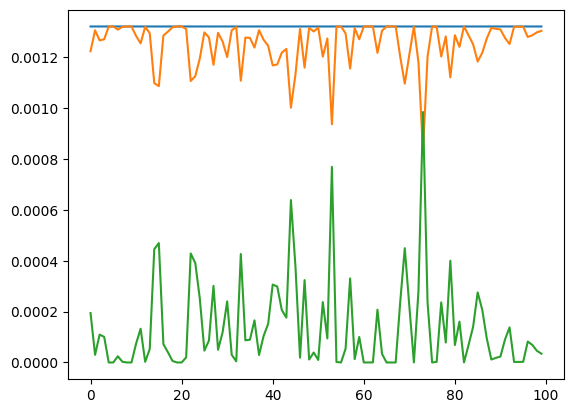

In [296]:
plt.plot(ke + pe / 2)
plt.plot(ke)
plt.plot(pe)

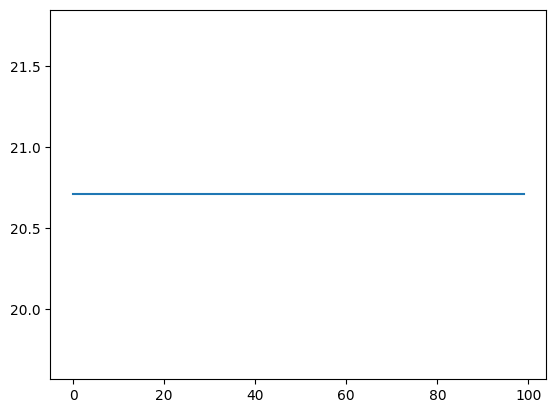

In [239]:
plt.plot(pe)